## Phase 2 Project Submission

Please fill out:
* Students names: Angella Bor | Jackline Njuguna | Vitelis Siocha | Mwenda Mugambi
* Student pace:  Part time 

# Project Overview

In this notebook, we'll conduct a comprehensive analysis of house sales data in a northwestern county using multiple linear regression modeling. Our goal is to gain insights into the factors that affect house prices and develop a predictive model that can estimate the value of homes based on various features.

## Stakeholder 

For this project, we will complete it on behalf of our primary stakeholder "Weichert Realtors." Weichert Realtors specializes in assisting homeowners in buying and selling homes in the northwestern county. 

## Business Problem

**Business Problem:** 
Weichert Realtors needs to provide valuable advice to homeowners regarding how home renovations may impact the estimated value of their homes and by what amount.

**Objective:**
- Develop a predictive model that can estimate the effect of different home renovations on the estimated home value.
- Provide actionable insights to homeowners about which renovations are likely to yield the highest return on investment (ROI).

**Why is this problem important?**
Homeowners frequently invest in home renovations to improve their living conditions and increase the value of their properties. However, they often lack guidance on which renovations are the most cost-effective in terms of increasing property value. By addressing this problem, Weichert Realtors can offer valuable guidance to homeowners, strengthen their relationships with clients, and potentially increase their business.

**Questions to answer:**
1. What influence does the qualitative aspects of a house have on its sale price?
2. Is there a correlation between quantitative features and the selling price of a house?
3. What suggestions can be made to property investors seeking to optimize their returns from commercial real estate investments?


# Data Exploration

In this section, We'll be going through the data sets we have to understand the structure and determine the ones we'll be using for this project.
 * We start by importing the libraries and the datasets that will be necessary for the process.


In [55]:
#Importing the necessary Libraries.
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


In [2]:
#Importing the data set
data = pd.read_csv("data/kc_house_data.csv") 
data.sample(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2502,6979970140,4/17/2015,475000.0,3,2.50,2370,3239,2.0,NO,NONE,...,8 Good,1950,420.0,2006,0.0,98072,47.7515,-122.174,2520,3431
17984,2892600056,1/6/2015,216000.0,2,1.00,1130,12500,1.0,NO,NONE,...,7 Average,1130,0.0,1953,0.0,98055,47.4514,-122.187,1270,10798
2865,7504030090,6/1/2014,660000.0,4,1.75,2780,9900,2.0,NaN,NONE,...,10 Very Good,2780,0.0,1978,0.0,98074,47.6348,-122.060,2600,12000
9612,3342101270,3/24/2015,698000.0,4,3.50,3630,5670,2.0,NO,NONE,...,10 Very Good,3630,0.0,1970,NaN,98056,47.5189,-122.206,1620,5400
10755,1023059190,3/24/2015,210000.0,3,1.50,1160,10125,1.0,NO,NONE,...,7 Average,1160,0.0,1959,0.0,98059,47.4919,-122.151,1440,10018
4859,629500170,3/26/2015,679950.0,4,2.50,2850,5664,2.0,NO,NONE,...,9 Better,2850,0.0,2001,0.0,98075,47.5835,-121.996,2850,5475
8950,2570500230,5/29/2014,400000.0,5,2.00,1930,9747,1.0,NaN,NONE,...,7 Average,1020,910.0,1962,0.0,98028,47.7743,-122.235,2040,9370
9779,2424059139,2/6/2015,900000.0,3,3.25,3870,33980,2.0,NO,NONE,...,10 Very Good,3150,720.0,1991,0.0,98006,47.5589,-122.117,3590,10750
508,5113400431,5/8/2014,615000.0,2,1.00,1540,6872,1.0,NO,NONE,...,7 Average,820,?,1946,0.0,98119,47.6454,-122.373,1420,5538
4543,7224500300,3/25/2015,221000.0,3,1.00,1240,5250,1.5,NO,NONE,...,6 Low Average,1240,0.0,1904,0.0,98055,47.4917,-122.206,1240,5250


In [3]:
# Checking the shape of our data
data.shape

(21597, 21)

We have (21 columns) and (21597) rows

In [4]:
# Checking the columns in our data frame
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

### Column Names and Descriptions for King County Data Set
* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
* `view` - Quality of view from house
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
* `grade` - Overall grade of the house. Related to the construction and design of the house.
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `zipcode` - ZIP Code used by the United States Postal Service
* `lat` - Latitude coordinate
* `long` - Longitude coordinate
* `sqft_living15` - The square footage of interior housing living space for the nearest 15 neighbors
* `sqft_lot15` - The square footage of the land lots of the nearest 15 neighbors

We start by getting a quick overview of our dataset using data.info() which provides a concise summary of essential information about the DataFrame.

In [5]:
# getting a quick overview of our data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

* From the output, we can see that several columns have missing values, such as 'waterfront', 'view' and 'yr_renovated' but there are no duplicate entries.

##### What are the really values in the 'sqft_basement'? 
Our expectation was that the dtypes for this column to be float type, but according to the information above it is an object type. Let's explore it further.

In [6]:
data['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
2400.0        1
20.0          1
1913.0        1
915.0         1
2500.0        1
Name: sqft_basement, Length: 304, dtype: int64

The column "sqft_basement" contains a place holder "?" which needs to be addressed in order to get the correct dtypes. 

## Data Processing

### Addressing Dtypes issue in "sqft_basement"
We intend to replace the "?" with the mode value of this column.

In [7]:
# Mode of column "sqft_basement"
data['sqft_basement'].mode()

0    0.0
dtype: object

In [8]:
# Replacing the "?" with the mode
data['sqft_basement'] = data['sqft_basement'].replace("?", 0.0)
# Change the dtype to float type
data['sqft_basement'] = data['sqft_basement'].astype("float")


In [9]:
data['sqft_basement'].sample(5)

6240      950.0
12245       0.0
1162     2020.0
4550     1010.0
11425       0.0
Name: sqft_basement, dtype: float64

## Filling Null Values

We now check the entries in these columns and to confirm they have the correct data type entries so that we can choose the best way to handle the missing values.

#### "Waterfront" Column

In [10]:
# Checking see the count of each data value in the Waterfront column
print(data["waterfront"].value_counts())

# Checking for missing values
print(f"Total Missing values:{data['waterfront'].isna().sum()}")

NO     19075
YES      146
Name: waterfront, dtype: int64
Total Missing values:2376


The "waterfront" column contains data denoting whether a home is waterfront or not. This data can be later be converted to binary data, indicating whether a home is waterfront (1) or not (0)

With the column having missing values. We assume that missing values in this column implies that the properties are not Waterfronts, Homeowners with waterfront homes are more likely to provide this information as compared to those without, who might leave the field blank during the data collection.

In [11]:
# Filling the missing values with (NO)
data["waterfront"] = data["waterfront"].fillna("NO")

# Confirming our changes worked
print(f"Total Missing values:{data['waterfront'].isna().sum()}")

Total Missing values:0


#### "View" Column

In [12]:
# Checking see the count of each data value in the View column
print(data["view"].value_counts())

# Checking for missing values
print(f"Total Missing values:{data['view'].isna().sum()}")

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64
Total Missing values:63


We see the range of view ratings are from from average to excellent. 
Majority of the homes are categorized as having no view, specifically labeled as "NONE."

To deal with the missing values in this column, we'll consider that If a home doesn't possess a significant view, it's likely that respondents skipped or left this section blank. 
With this logic, tt would be resonable for us to fill the missing values with "NONE"

In [13]:
# Filling the missing values with (NONE)
data["view"] = data["view"].fillna("NONE")

In [14]:
print(data["view"].value_counts())
# Confirming our changes worked
print(f"Total Missing values:{data['view'].isna().sum()}")

NONE         19485
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64
Total Missing values:0


#### "yr_renovated" Column

In [15]:
# Checking see the count of each data value in the "yr_renovated" column
print(data["yr_renovated"].value_counts())

# Checking for missing values
print(f"Total Missing values:{data['yr_renovated'].isna().sum()}")

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64
Total Missing values:3842


This column represents the year of home renovation.

The data represents the year as a numerical value. In this context, zero implies that the home has never been renovated. 
Since zero is the most popular value, we can conclude that the missing values signifies that the home was not renovated. This makes it  reasonable for us to go ahead with this assumption to deal with the missing values.

In [16]:
# Filling the missing values with (0)
data["yr_renovated"] = data["yr_renovated"].fillna(0)

In [17]:
# Confirming our changes worked
print(f"Total Missing values:{data['yr_renovated'].isna().sum()}")

Total Missing values:0


In [18]:
# Getting a quick overview of our data to confirm we no longer have missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     21597 non-null  object 
 9   view           21597 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  float64
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   21597 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

* Great now that we can see we no longer have any missing values.

Next we can get a quick overview of the distribution and central tendency of the data to get more nsights into the dataset's characteristics

In [19]:
# Getting summary statistics of our dataset
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,285.716581,1970.999676,68.758207,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,439.819830,29.375234,364.037499,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,550.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


From the result we can see that
* Home prices range from $ 78,000 -  $ 7,700,000
* The mean house price in the dataset is approximately $540,296.
* Most houses have between 3 and 4 bedrooms on average (mean of approximately 3.37)
* There is also a maximum of 33 bedrooms-(This could be an outlier or a data entry error.)
* The average number of bathrooms is approximately 2.12, with a range from 0.5 to 8 bathrooms per house.
* The houses in the dataset were built over a wide time span, with a mean construction year of around 1971, suggesting both older and newer properties.
* Most houses have 1.494 floors on average, with a minimum of 1 floor and a maximum of 3.5 floors.
* The 'yr_renovated' column indicates that some houses have been renovated, with the maximum renovation year being 2015. However, a large number of houses have no recorded renovations.

In order for us to confirm if 33 bedrooms is an outlier, We can use a boxplot.

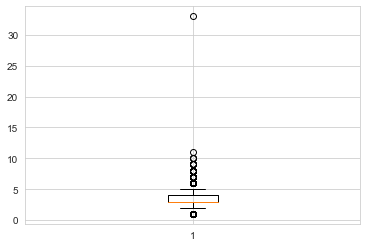

In [20]:
# Plotting a boxplot
plt.boxplot(data["bedrooms"]);

In deed we can see that it is an outlier.
* In this case, it would be safe to assume that this was a data enty error. 33 instead of 3. We can go ahead to replace 33 with 3. 

In [21]:
# replaces 33 with 3 
data["bedrooms"] = data["bedrooms"].replace(33, 3) 

# Checking to see if it has been changed
data["bedrooms"].max()

11

## Dropping unnecessary columns
Based on the questions we want to answer, the 'id', 'date', 'zipcode', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'lat', 'long' columns will not be essensial in our analysis. We can go ahead and drop them.

In [22]:
# Dropping the columns and assigning it to a new df
new_data = data.drop(['id','date','zipcode', 'sqft_living15', 'sqft_lot15', 'lat', 'long'], axis=1)
new_data.head(20)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated
0,221900.0,3,1.00,1180,5650,1.0,NO,NONE,Average,7 Average,1180,0.0,1955,0.0
1,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0
2,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,0.0
3,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0
4,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0
5,1230000.0,4,4.50,5420,101930,1.0,NO,NONE,Average,11 Excellent,3890,1530.0,2001,0.0
6,257500.0,3,2.25,1715,6819,2.0,NO,NONE,Average,7 Average,1715,0.0,1995,0.0
7,291850.0,3,1.50,1060,9711,1.0,NO,NONE,Average,7 Average,1060,0.0,1963,0.0
8,229500.0,3,1.00,1780,7470,1.0,NO,NONE,Average,7 Average,1050,730.0,1960,0.0
9,323000.0,3,2.50,1890,6560,2.0,NO,NONE,Average,7 Average,1890,0.0,2003,0.0


### Checking for Duplicates

In [23]:
#finding total number of duplicates
# Duplicated entries
def identify_duplicates(new_data):
    """Simple function to identify any duplicates"""
    # identify the duplicates (dataframename.duplicated() , can add .sum() to get total count)
    # empty list to store Bool results from duplicated
    duplicates = []
    for i in new_data.duplicated():
        duplicates.append(i)
    # identify if there is any duplicates. (If there is any we expect a True value in the list duplicates)
    duplicates_set = set(duplicates)
    if (len(duplicates_set) == 1):
        print("The Data has no duplicates")
    else:
        no_true = 0
        for val in duplicates:
            if (val == True):
                no_true += 1
        # percentage of the data represented by duplicates
        duplicates_percentage = np.round(((no_true / len(new_data)) * 100), 3)
        print(f"The Data has {no_true} duplicated rows.\nThis constitutes {duplicates_percentage}% of the data set.")
identify_duplicates(new_data)

The Data has 8 duplicated rows.
This constitutes 0.037% of the data set.


#### Dropping Duplicate rows

In [24]:
# Drop rows that are duplicated based on all columns
new_data = new_data.drop_duplicates()

### How are the features Distributed?
Now that we've dropped the unnecessary we can visualize the features are distributed

* We start by looking at the distribution of the house prices.

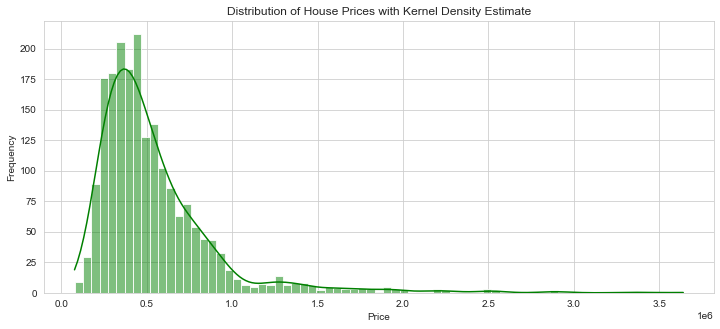

In [25]:
# Create a distribution plot of the target variable "price"
plt.figure(figsize=(12, 5))
sns.histplot(new_data.sample(2000), x="price", kde=True, color='green')

# Set labels and title
plt.xlabel("Price")
plt.ylabel('Frequency')
plt.title("Distribution of House Prices with Kernel Density Estimate");

In [26]:
new_data.head(2)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated
0,221900.0,3,1.00,1180,5650,1.0,NO,NONE,Average,7 Average,1180,0.0,1955,0.0
1,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0


* We start by looking at the distribution of other features.

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'bathrooms'}>],
       [<AxesSubplot:title={'center':'sqft_living'}>,
        <AxesSubplot:title={'center':'sqft_lot'}>,
        <AxesSubplot:title={'center':'floors'}>],
       [<AxesSubplot:title={'center':'sqft_above'}>,
        <AxesSubplot:title={'center':'sqft_basement'}>,
        <AxesSubplot:title={'center':'yr_built'}>],
       [<AxesSubplot:title={'center':'yr_renovated'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

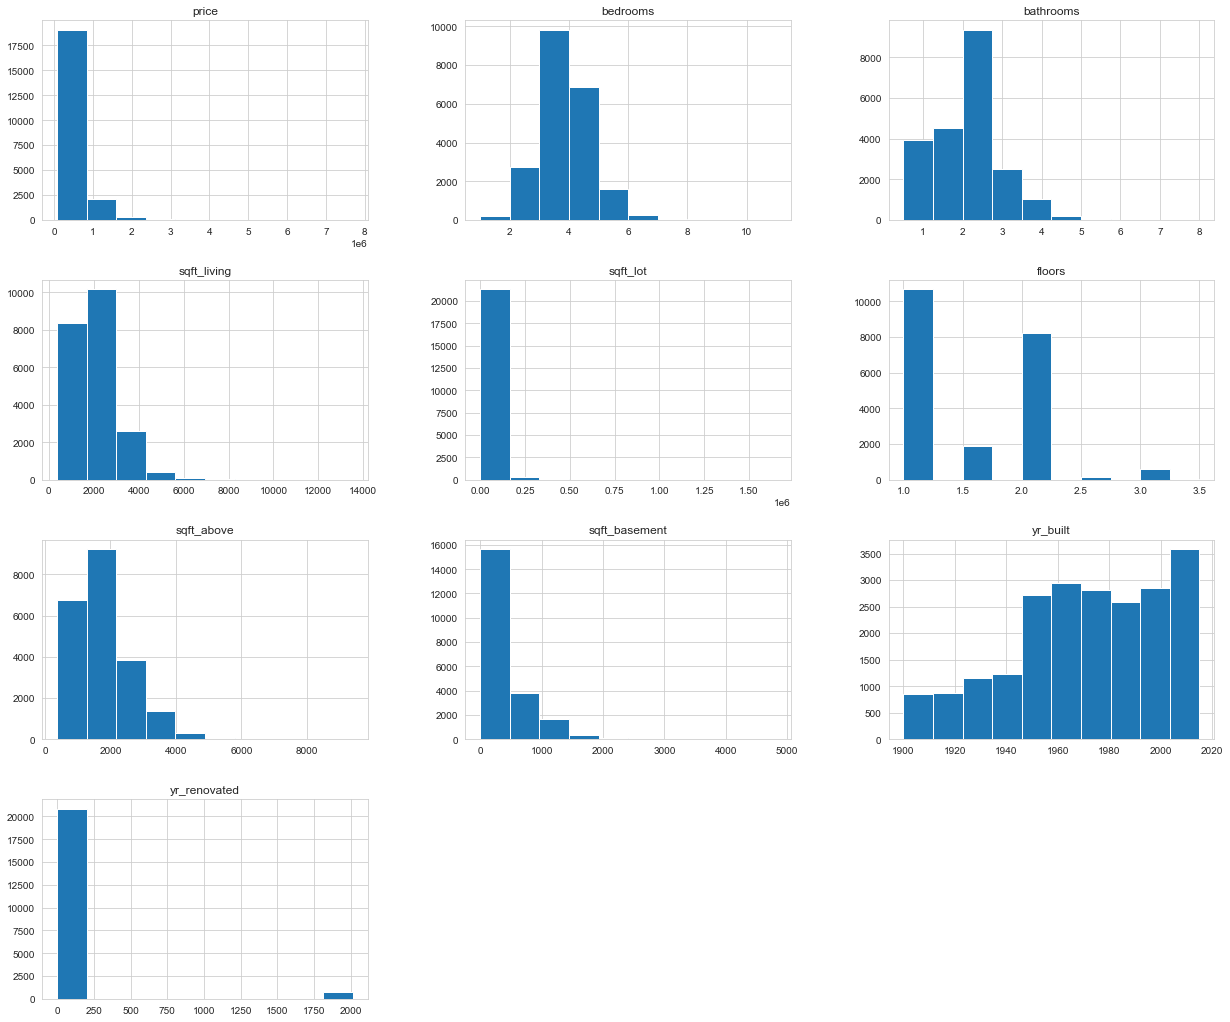

In [27]:
# Distibution of other column variables 
def histo(new_data):
    return new_data.hist(figsize=(21,18))
histo(new_data)

## EXPLORATORY DATA ANALYSIS

### Relationship Between Price and Number of Bedrooms

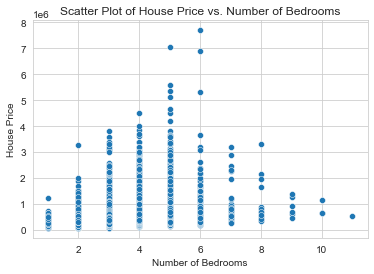

In [28]:
# plot of House Price vs. Number of Bedrooms
sns.scatterplot(data=new_data, x='bedrooms', y='price')
plt.xlabel('Number of Bedrooms')
plt.ylabel('House Price')
plt.title('Scatter Plot of House Price vs. Number of Bedrooms')
plt.show()

Houses with 5-6 bedrooms have higher selling prices. Suprisingly, houses with  less than 3 or more than 8 bedrooms have low prices.

### Relationship Between Price and Number of Bathrooms

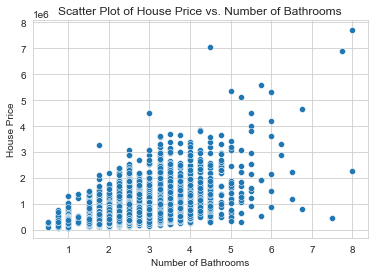

In [29]:
# plot of House Price vs. Number of Bathrooms
sns.scatterplot(data=new_data, x='bathrooms', y='price')
plt.xlabel('Number of Bathrooms')
plt.ylabel('House Price')
plt.title('Scatter Plot of House Price vs. Number of Bathrooms')
plt.show()

The visualization result shows a positive linear relationship between the number of bathrooms the house has and its selling price. The more the bedrooms, the higher the house prices.

### Relationship Between Price and Square Footage Size

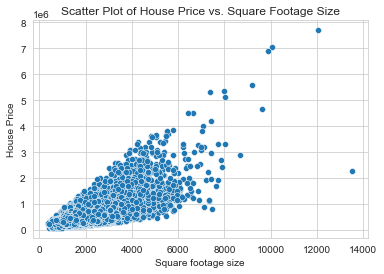

In [30]:
# plot of House Price vs. Square footage size
sns.scatterplot(data=new_data, x='sqft_living', y='price')
plt.xlabel('Square footage size')
plt.ylabel('House Price')
plt.title('Scatter Plot of House Price vs. Square Footage Size')
plt.show()

The plot shows a positive linear correlation between the house price and its square footage size. Houses with larger square footage sizes are sold at better prices.

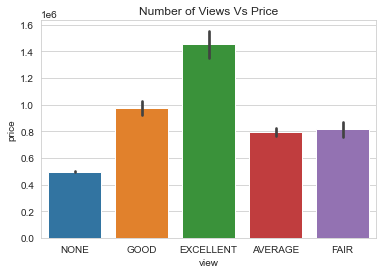

In [31]:
#Plotting a barplot of 'view' against 'price'
sns.barplot(x=new_data['view'], y=new_data['price']).set(title='Number of Views Vs Price');

Houses with good rating views have higher or better prices

### Encoding Categorical Data
#### View


In [32]:
new_data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated
0,221900.0,3,1.00,1180,5650,1.0,NO,NONE,Average,7 Average,1180,0.0,1955,0.0
1,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0
2,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,0.0
3,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0
4,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0


In [33]:
# Relacing the viewing elements with numbers allocated to them
new_data["view"].replace("FAIR", 1, inplace = True)
new_data["view"].replace("AVERAGE", 2, inplace = True)
new_data["view"].replace("GOOD", 3, inplace = True)
new_data["view"].replace("EXCELLENT", 4, inplace = True)
new_data["view"].replace("NONE", 0, inplace = True)

In [34]:
new_data["view"].head(2)

0    0
1    0
Name: view, dtype: int64

#### Condition

In [35]:
# Define a mapping dictionary to encode the values
condition_mapping = {'Average': 0, 'Very Good': 1, 'Good': 2, 'Poor': 3, 'Fair': 4}

# Use the map() function to apply the mapping to the column
new_data['condition'] = new_data['condition'].map(condition_mapping)

# Display the DataFrame with the encoded values
print(new_data)

          price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0      221900.0         3       1.00         1180      5650     1.0   
1      538000.0         3       2.25         2570      7242     2.0   
2      180000.0         2       1.00          770     10000     1.0   
3      604000.0         4       3.00         1960      5000     1.0   
4      510000.0         3       2.00         1680      8080     1.0   
...         ...       ...        ...          ...       ...     ...   
21592  360000.0         3       2.50         1530      1131     3.0   
21593  400000.0         4       2.50         2310      5813     2.0   
21594  402101.0         2       0.75         1020      1350     2.0   
21595  400000.0         3       2.50         1600      2388     2.0   
21596  325000.0         2       0.75         1020      1076     2.0   

      waterfront  view  condition          grade  sqft_above  sqft_basement  \
0             NO     0          0      7 Average        1180        

#### Waterfront

In [36]:
# Create a mapping dictionary
waterfront_mapping = {'YES': 1, 'NO': 0}

# Use the map() function to apply the mapping
new_data['waterfront'] = new_data['waterfront'].map(waterfront_mapping)

# Display the DataFrame with the encoded values
print(new_data)

          price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0      221900.0         3       1.00         1180      5650     1.0   
1      538000.0         3       2.25         2570      7242     2.0   
2      180000.0         2       1.00          770     10000     1.0   
3      604000.0         4       3.00         1960      5000     1.0   
4      510000.0         3       2.00         1680      8080     1.0   
...         ...       ...        ...          ...       ...     ...   
21592  360000.0         3       2.50         1530      1131     3.0   
21593  400000.0         4       2.50         2310      5813     2.0   
21594  402101.0         2       0.75         1020      1350     2.0   
21595  400000.0         3       2.50         1600      2388     2.0   
21596  325000.0         2       0.75         1020      1076     2.0   

       waterfront  view  condition          grade  sqft_above  sqft_basement  \
0               0     0          0      7 Average        1180      

#### Grade

In [37]:
# Define a mapping dictionary to extract numerical values
grade_mapping = {
    '10 Very Good': 10,
    '11 Excellent': 11,
    '12 Luxury': 12,
    '13 Mansion': 13,
    '3 Poor': 3,
    '4 Low': 4,
    '5 Fair': 5,
    '6 Low Average': 6,
    '7 Average': 7,
    '8 Good': 8,
    '9 Better': 9
}

# Use the map() function to extract numerical values and create a new column
new_data['grade'] = new_data['grade'].map(grade_mapping)

# Display the DataFrame with the extracted numerical values
print(new_data)

          price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0      221900.0         3       1.00         1180      5650     1.0   
1      538000.0         3       2.25         2570      7242     2.0   
2      180000.0         2       1.00          770     10000     1.0   
3      604000.0         4       3.00         1960      5000     1.0   
4      510000.0         3       2.00         1680      8080     1.0   
...         ...       ...        ...          ...       ...     ...   
21592  360000.0         3       2.50         1530      1131     3.0   
21593  400000.0         4       2.50         2310      5813     2.0   
21594  402101.0         2       0.75         1020      1350     2.0   
21595  400000.0         3       2.50         1600      2388     2.0   
21596  325000.0         2       0.75         1020      1076     2.0   

       waterfront  view  condition  grade  sqft_above  sqft_basement  \
0               0     0          0      7        1180            0.0   
1  

## Modelling

### Correlation of other features/variables with House Price

In [38]:
# Calculate the correlation matrix
correlation_matrix = abs(new_data.corr())

# Get the correlation of 'price' with all other columns
price_correlations = correlation_matrix['price']
price_correlations

price            1.000000
bedrooms         0.316007
bathrooms        0.525936
sqft_living      0.701940
sqft_lot         0.089868
floors           0.256952
waterfront       0.264310
view             0.393616
condition        0.034507
grade            0.668078
sqft_above       0.605397
sqft_basement    0.321125
yr_built         0.054018
yr_renovated     0.117921
Name: price, dtype: float64

### What is the most correlated column feature with price?
Let's get the most correlated column feature name with its correlation coefficient

In [39]:
# Find the most correlated column (excluding 'price' itself)
most_correlated_column = price_correlations.drop('price').idxmax()

# Get the correlation coefficient for the most correlated column
max_correlation_coefficient = price_correlations[most_correlated_column]

print(f"The most correlated column with 'price' is '{most_correlated_column}' with a correlation coefficient of {max_correlation_coefficient:.2f}")

The most correlated column with 'price' is 'sqft_living' with a correlation coefficient of 0.70


### What is the most correlated feature with other features excluding price?

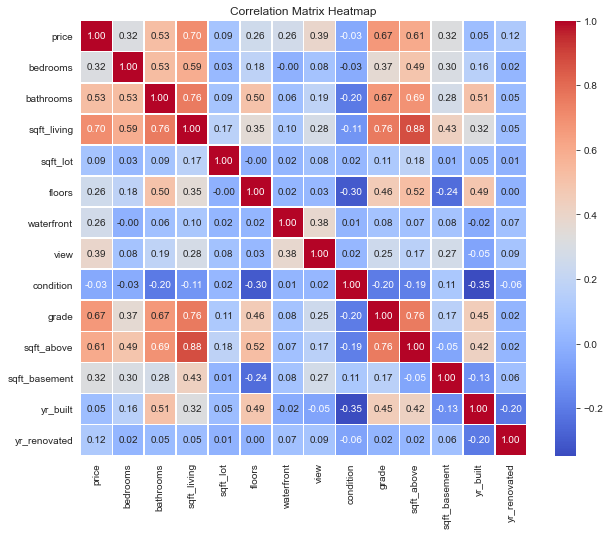

In [40]:
# Calculate the correlation matrix
correlation_matrix = new_data.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

We now check if there are any variables with a correlation of more than 0.75

In [41]:
abs(correlation_matrix)>0.75

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated
price,True,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,True,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,True,True,False,False,False,False,False,True,True,False,False,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,True,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,True,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,True,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,True,False,False,False,False,False
grade,False,False,False,True,False,False,False,False,False,True,True,False,False,False


The most collerated feature with other features excluding price is 'sqft_living'.
Since 'sqft_living' has two most auto-correlation with other features after price, we will drop it to avoid multicollinearity issues when modelling

In [42]:
# Drop "sqft_living" feature
new_data = new_data.drop(columns=["sqft_living"])

In [43]:
new_data.head(3) # Rechecking to ensure the "sqft_living" has been dropped.

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated
0,221900.0,3,1.00,5650,1.0,0,0,0,7,1180,0.0,1955,0.0
1,538000.0,3,2.25,7242,2.0,0,0,0,7,2170,400.0,1951,1991.0
2,180000.0,2,1.00,10000,1.0,0,0,0,6,770,0.0,1933,0.0


In [44]:
# Checking again to get the most correlated feature with price
# Calculate the correlation matrix
correlation_matrix = abs(new_data.corr())

# Get the correlation of 'price' with all other columns
price_correlations = correlation_matrix['price']
price_correlations

price            1.000000
bedrooms         0.316007
bathrooms        0.525936
sqft_lot         0.089868
floors           0.256952
waterfront       0.264310
view             0.393616
condition        0.034507
grade            0.668078
sqft_above       0.605397
sqft_basement    0.321125
yr_built         0.054018
yr_renovated     0.117921
Name: price, dtype: float64

## 1. Base Model

## 1. Baseline Model
We have found our most correlated column with price is 'grade'. Let's now build our Baseline model with this column.
Our baseline model is a simple linear regression that take the equation:

Y= aX+b

#### In this equation:
Y is the dependent variable ('price').

X is the independent variable ('grade').

a is the slope of the regression line, representing the change in Y for a one-unit change in X. It is also known as the   regression coefficient or the coefficient of the independent variable.

b is the y-intercept, representing the value of Y when X is zero.

#### Setting up variable, fitting linear regression model and viewing the model results

In [45]:
#Declaring Variables
y = new_data['price']
X_baseline = new_data['grade']

#Fitting model
baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()

#Printing Results
print(baseline_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                 1.740e+04
Date:                Sat, 09 Sep 2023   Prob (F-statistic):               0.00
Time:                        00:38:01   Log-Likelihood:            -3.0090e+05
No. Observations:               21589   AIC:                         6.018e+05
Df Residuals:                   21587   BIC:                         6.018e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.062e+06   1.23e+04    -86.419      0.0

#### Summary findings and interpretation
The linear regression model fitted above uses the 'grade' as the independent variable to predict the 'price' of houses. The R-squared value of 0.446 indicates that approximately 44.6% of the variance in house prices can be explained by the 'grade.' The coefficient for 'grade' is 209,200, suggesting that, on average, a one-unit increase in the 'grade' results in an increase of $209,200 in the house price. The constant term of -1,062,000 represents the estimated price when 'grade' is zero. The p-values are close to zero, indicating that the 'grade' is statistically significant in predicting house prices. The model fits the data well, although there might be some multicollinearity concerns, given the high coefficient value for 'grade.'

#### Residuals of the Baseline Model

In [46]:
# Calculate predicted values using the baseline model
predicted_values = baseline_results.predict(sm.add_constant(X_baseline))

# Calculate residuals (observed - predicted)
residuals = y - predicted_values

# Print the first few residuals
print(residuals.head())

0   -180824.561898
1    135275.438102
2    -13504.562520
3    201275.438102
4   -101944.561277
dtype: float64


Negative residuals indicate that the model underestimated the prices, while positive residuals indicate overestimation. The values in the displayed residuals are the specific differences for the first few data points in the dataset.

#### Visual representation of the Baseline Model residual

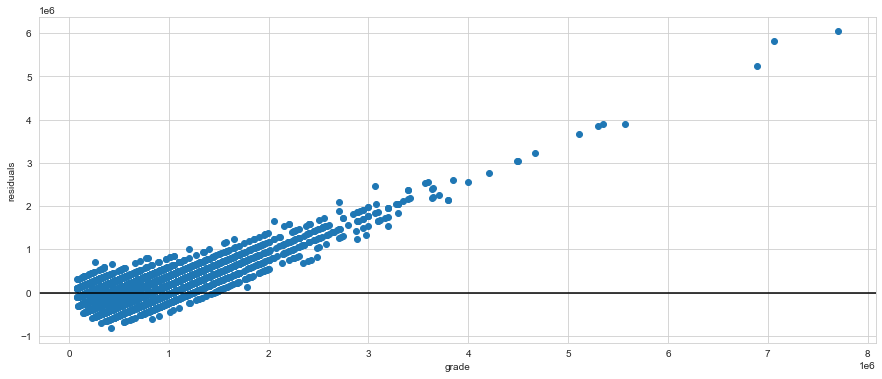

In [47]:
#Scatter plot of residuals
fig, ax = plt.subplots(figsize=(15,6))
ax.scatter(new_data["price"], baseline_results.resid)
ax.axhline(y=0, color="black")
ax.set_xlabel("grade")
ax.set_ylabel("residuals");

## 2. Multiple Linear Regression Model

The four assumptions kept for multiple Linear Regression Models below include: 
1. No multicollinearity
2. Linear relationship between explanatory and response variables
3. Homoscedasticity of error terms
4. Normal distribution of model residuals

#### a. Using Continuous data and Categorical features to build multiple regression models
Looking at the four categorical features above, the condition states and grades of the house are more likely to influence the house prices. Thus, we select these variables for our multiple regression model to check how they influence the house prices when combined with numerical variables.

#### i. Model Continuous features and grade column
We first start to iterate one categorical feature('grade') with continuous variables ("bedrooms", "bathrooms", "sqft_lot", "sqft_basement", "sqft_above", "floors") as below and view the model summary results

In [48]:
x_iterated_one = new_data[["grade", "bedrooms", "bathrooms", "sqft_lot", "sqft_basement", "sqft_above", 
                           "floors"]]
iterated_model_one = sm.OLS(y, sm.add_constant(x_iterated_one))
iterated_results_one = iterated_model_one.fit()
print(iterated_results_one.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     3774.
Date:                Sat, 09 Sep 2023   Prob (F-statistic):               0.00
Time:                        00:38:01   Log-Likelihood:            -2.9865e+05
No. Observations:               21589   AIC:                         5.973e+05
Df Residuals:                   21581   BIC:                         5.974e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.179e+05   1.53e+04    -33.759

The multiple linear regression model, incorporating continuous variables (bedrooms, bathrooms, sqft_lot, sqft_basement, sqft_above, floors) and one categorical variable (view), shows an improved performance compared to the baseline model. The R-squared value has increased to 0.545, indicating that about 54.5% of the variance in price is explained by the model. The coefficients and their associated statistics for each predictor variable are provided in the summary output. All continuous variables, except for floors, appear to be statistically significant predictors of price. The view variable also has a significant impact on price. However, the model may suffer from multicollinearity issues due to a large condition number.

#### ii. Model Continuous features and grade column

In [53]:
x_iterated_two = new_data[["condition", "bedrooms", "bathrooms", "sqft_lot", "sqft_basement", "sqft_above", 
                           "floors"]]
iterated_model_two = sm.OLS(y, sm.add_constant(x_iterated_two))
iterated_results_two = iterated_model_two.fit()
print(iterated_results_two.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     3222.
Date:                Sat, 09 Sep 2023   Prob (F-statistic):               0.00
Time:                        00:39:19   Log-Likelihood:            -2.9956e+05
No. Observations:               21589   AIC:                         5.991e+05
Df Residuals:                   21581   BIC:                         5.992e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.485e+04   8297.474      6.611

This second model, which includes the categorical variable condition along with continuous variables, shows an R-squared of 0.511, indicating 51.1% of price variance explained. All predictors are statistically significant. This model performs similarly to the previous one, suggesting condition may be a valuable predictor alongside the other features. 

#### b. Model using only categorical features

In [50]:
x_iterated_three = new_data[["condition","waterfront","grade", "view"]]
iterated_model_three = sm.OLS(y, sm.add_constant(x_iterated_three))
iterated_results_three = iterated_model_three.fit()
print(iterated_results_three.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     5966.
Date:                Sat, 09 Sep 2023   Prob (F-statistic):               0.00
Time:                        00:38:01   Log-Likelihood:            -2.9924e+05
No. Observations:               21589   AIC:                         5.985e+05
Df Residuals:                   21584   BIC:                         5.985e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.009e+06   1.22e+04    -82.846      0.0

The third model, using only categorical features (condition, waterfront, grade, view), has an R-squared of 0.525, explaining 52.5% of price variance. All categorical predictors are statistically significant below the chosen p_value of 0.05. This model simplifies the model significantly and performs competitively, suggesting that categorical features alone can provide valuable predictive power.

#### c. Model using only continuous variables

In [51]:
x_iterated_four = new_data[["view", "bedrooms", "bathrooms", "sqft_lot", "sqft_basement", "sqft_above", 
                           "floors", "yr_renovated", "yr_built"]]
iterated_model_four = sm.OLS(y, sm.add_constant(x_iterated_four))
iterated_results_four = iterated_model_four.fit()
print(iterated_results_four.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     3370.
Date:                Sat, 09 Sep 2023   Prob (F-statistic):               0.00
Time:                        00:38:01   Log-Likelihood:            -2.9781e+05
No. Observations:               21589   AIC:                         5.956e+05
Df Residuals:                   21579   BIC:                         5.957e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.977e+06   1.39e+05     42.946

The fourth model, utilizing only continuous variables, demonstrates an R-squared value of 0.584, indicating that 58.4% of the variance in price is explained. All continuous variables are statistically significant predictors of price. This model outperforms the previous models, suggesting that using only continuous features provides a strong predictive power for price. Nevertheless, multicollinearity is a potential issue.

#### d. Model using specific continuous variables
We now exclude "yr_renovated", "yr_built" and constant features to see if our model can improve than the previous models.

In [66]:
# Define the variables
y = new_data["price"]
X = new_data[["bedrooms", "bathrooms", "sqft_lot", "sqft_basement", "sqft_above", "floors"]]
# Create and fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.843
Model:                            OLS   Adj. R-squared (uncentered):              0.843
Method:                 Least Squares   F-statistic:                          1.938e+04
Date:                Sat, 09 Sep 2023   Prob (F-statistic):                        0.00
Time:                        01:42:42   Log-Likelihood:                     -2.9969e+05
No. Observations:               21589   AIC:                                  5.994e+05
Df Residuals:                   21583   BIC:                                  5.994e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

The fifth model, using specific continuous variables (bedrooms, bathrooms, sqft_lot, sqft_basement, sqft_above, floors), exhibits an R-squared value of 0.843, indicating a high explanatory power of 84.3%. All selected continuous variables are statistically significant. The model performs exceptionally well, but the absence of a constant term may affect its generalizability. Thus, we consider evaluating its performance on a validation dataset to ensure its validity given that this is the only model that has strongly fitted the data with high explanatory power of more than eighty percent.

### Performance of the fifth model
We first split the data into training and validation sets using train_test_split. Then, we train the model using the training data. Finally, we make predictions on the validation set and evaluate the model's performance.

In [58]:
# Define the dependent variable (y) and independent variables (X)
y = new_data["price"]
X = new_data[["bedrooms", "bathrooms", "sqft_lot", "sqft_basement", "sqft_above", "floors"]]

# Step 1: Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Train the Model
model = sm.OLS(y_train, X_train).fit()

# Step 3: Evaluate on the Validation Set
y_pred = model.predict(X_val)

# Calculate R-squared on the validation set
r_squared = 1 - (np.sum((y_val - y_pred)**2) / np.sum((y_val - np.mean(y_val))**2))

# Print R-squared value
print(f"R-squared on Validation Set: {r_squared:.3f}")
# Print model summary
print(model.summary())

R-squared on Validation Set: 0.525
                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.844
Model:                            OLS   Adj. R-squared (uncentered):              0.844
Method:                 Least Squares   F-statistic:                          1.561e+04
Date:                Sat, 09 Sep 2023   Prob (F-statistic):                        0.00
Time:                        01:04:45   Log-Likelihood:                     -2.3955e+05
No. Observations:               17271   AIC:                                  4.791e+05
Df Residuals:                   17265   BIC:                                  4.792e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
---

The fifth model, using specific continuous variables, achieves an impressive R-squared value of 0.844 on the validation set. This indicates that approximately 84.4% of the variance in housing prices is explained by the model. The chosen features (bedrooms, bathrooms, sqft_lot, sqft_basement, sqft_above, floors) are highly influential in predicting prices.

### Summary and Recommendations
#### Summary:
In this comprehensive analysis of house sales data for a northwestern county, multiple linear regression models were employed to understand the factors influencing house prices. The dataset contained information on various features like bedrooms, bathrooms, square footage, condition, grade, and more.

Several key findings emerged from the analysis:

Significant Predictors: The regression models revealed that certain features strongly influence house prices. These include the number of bedrooms, bathrooms, square footage, condition, grade, and view.

High Predictive Power: The best-performing model, using specific continuous variables, achieved an R-squared value of 0.844, indicating that approximately 84.4% of the variance in housing prices can be explained by the model.

Recommendations: Based on the analysis, several recommendations can be made to assist homeowners and Weichert Realtors:

a. Renovations Impact on Price: Emphasize the importance of specific renovations, such as increasing bedrooms or bathrooms, and enhancing the overall condition and grade of the property.

b. Maximizing ROI: Advise homeowners on renovations that are likely to yield the highest return on investment.

c. Consider Square Footage: Highlight the significance of square footage in determining the value of a property.

Additional Considerations:

Further Data Exploration: Exploring additional variables, such as location-related features or neighborhood characteristics, could provide deeper insights into price determinants.

Continuous Monitoring: Keep track of market trends and adjust recommendations accordingly to stay competitive and provide the most up-to-date advice.

Model Validation: Continually validate the models with new data to ensure their accuracy and relevance in the evolving real estate market.

Multicollinearity Assessment: Monitor for multicollinearity issues, especially in models with multiple predictors, to ensure the stability of the regression coefficients.

By leveraging these insights and recommendations, Weichert Realtors can offer valuable guidance to homeowners, strengthen client relationships, and potentially increase business in the northwestern county real estate market.